<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-predictions-and-GT" data-toc-modified-id="Load-predictions-and-GT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load predictions and GT</a></span></li><li><span><a href="#Static-thresholds" data-toc-modified-id="Static-thresholds-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Static thresholds</a></span></li><li><span><a href="#NumThresh" data-toc-modified-id="NumThresh-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NumThresh</a></span></li><li><span><a href="#SGLthresh" data-toc-modified-id="SGLthresh-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SGLthresh</a></span></li><li><span><a href="#heuThresh" data-toc-modified-id="heuThresh-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>heuThresh</a></span></li></ul></div>

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support, classification_report

import pickle
import time
import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.get_device_name(0))

print("pytorch version:", torch.__version__)


cuda:0 GeForce GTX 1080
pytorch version: 1.4.0


In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True

In [3]:
def print_scores(gt_y, preds):
    print(classification_report(gt_y, preds, digits=3))    
    set_accuracy = accuracy_score(gt_y, preds)
    print('set acc: %.3f'%(set_accuracy))


def print_thresholds(thresh, nb_classes):
    s=''
    for k in range(nb_classes):
        s += '%.3f '%(thresh[k])
    print(s)

    
def save_thresholds(thresh, fpath):
    nb_classes = len(thresh)
    with open(fpath, 'wt') as fh:
        for k in range(nb_classes):
            fh.write("%.6f\n"%(thresh[k]))
        
        
def binarize_probs(probs, thresholds):
    
    nb_classes = probs.shape[-1]
    binarized_output = np.zeros_like(probs)
    
    for k in range(nb_classes):
        binarized_output[:, k] = (np.sign(probs[:, k] - thresholds[k]) + 1) // 2
    
    return binarized_output


# Load predictions and GT

In [4]:
val_pred_tensor = torch.load('datasets/dcase2017/predictions_tensor_validation.pt')
val_gt_tensor = torch.load('datasets/dcase2017/gt_tensor_validation.pt')
val_pred_np = val_pred_tensor.clone().cpu().numpy()
val_gt_np = val_gt_tensor.clone().cpu().numpy()

desed_pred_tensor = torch.load('datasets/dcase2017/predictions_tensor_eval.pt')
desed_gt_tensor = torch.load('datasets/dcase2017/gt_tensor_eval.pt')
desed_pred_np = desed_pred_tensor.clone().cpu().numpy()
desed_gt_np = desed_gt_tensor.clone().cpu().numpy()

# put tensors onto a GPU
val_pred_tensor = val_pred_tensor.to(device)
val_gt_tensor = val_gt_tensor.to(device)
desed_pred_tensor = desed_pred_tensor.to(device)
desed_gt_tensor = desed_gt_tensor.to(device)

nb_classes=val_gt_tensor.size(1)
print(nb_classes)

val_pred_tensor.size(), val_gt_tensor.size(), val_pred_np.shape, val_gt_np.shape, desed_pred_tensor.size(), desed_gt_tensor.size(), desed_pred_np.shape, desed_gt_np.shape

17


(torch.Size([488, 17]),
 torch.Size([488, 17]),
 (488, 17),
 (488, 17),
 torch.Size([1103, 17]),
 torch.Size([1103, 17]),
 (1103, 17),
 (1103, 17))

(array([418.,   9.,  13.,  11.,   3.,  11.,   5.,   6.,   8.,   4.]),
 array([8.7517869e-08, 9.2968538e-02, 1.8593699e-01, 2.7890542e-01,
        3.7187389e-01, 4.6484232e-01, 5.5781078e-01, 6.5077925e-01,
        7.4374765e-01, 8.3671612e-01, 9.2968458e-01], dtype=float32),
 <a list of 10 Patch objects>)

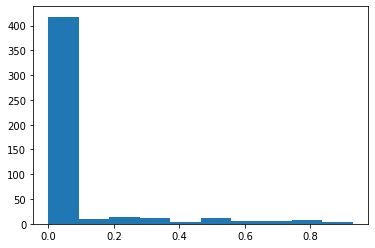

In [5]:
plt.hist(val_pred_np[:,9])

In [6]:
noise = torch.normal(mean=0.1*torch.ones(val_pred_np.shape), std=0.1)
noise = torch.clamp(noise, 0, 1)

(array([139.,  52.,  85.,  53.,  61.,  47.,  26.,  14.,   6.,   5.]),
 array([0.        , 0.03789912, 0.07579824, 0.11369736, 0.15159647,
        0.1894956 , 0.22739471, 0.26529384, 0.30319294, 0.34109208,
        0.3789912 ], dtype=float32),
 <a list of 10 Patch objects>)

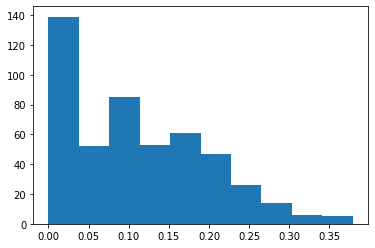

In [7]:
plt.hist(noise[:,0].cpu().numpy())

# Static thresholds

In [5]:
static_thresh = 0.3

val_bin_pred = binarize_probs(val_pred_np, [static_thresh]*nb_classes)
test_bin_pred = binarize_probs(desed_pred_np, [static_thresh]*nb_classes)

In [6]:
print("val")
print_scores(val_gt_np, val_bin_pred)
print("test")
print_scores(desed_gt_np, test_bin_pred)

# f1 = f1_score(val_gt_np, val_bin_pred, average='micro')
# print("%.3f"%f1)

# myf1 = my_calculate_f1(val_gt_np, val_pred_np, thresholds=[static_thresh]*nb_classes, average='micro')
# print("%.3f"%myf1)

# binarized_output = np.zeros_like(val_gt_np)
#     #     print('class num:', classes_num)
# thresholds=[static_thresh]*nb_classes
# for k in range(nb_classes):
#     binarized_output[:, k] = (np.sign(val_pred_np[:, k] - thresholds[k]) + 1) // 2

# np.allclose(val_bin_pred, binarized_output)
# # val_bin_pred[:10], binarized_output[:10]

val
              precision    recall  f1-score   support

           0      1.000     0.467     0.636        30
           1      0.833     0.333     0.476        30
           2      0.909     0.333     0.488        30
           3      0.857     0.400     0.545        30
           4      0.556     0.500     0.526        30
           5      0.821     0.767     0.793        30
           6      0.667     0.250     0.364        32
           7      0.446     0.714     0.549        35
           8      0.784     0.935     0.853        31
           9      0.600     0.771     0.675        35
          10      0.895     0.567     0.694        30
          11      0.271     0.900     0.417        60
          12      0.429     0.094     0.154        32
          13      0.538     0.226     0.318        31
          14      0.429     0.550     0.482        60
          15      0.654     0.567     0.607        30
          16      0.875     0.560     0.683        50

   micro avg      0.52

/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NumThresh

In [10]:
from sgl_utils.opt import Adam
from sgl_utils.numThresh import calculate_f1, calculate_at_gradient, optimize_at_with_gd, optimize_prec_and_rec_with_gd, calculate_prec_and_rec_gradient, calculate_prec_and_rec
from sklearn import metrics

In [11]:
t=0.3
thresh = [t]*nb_classes

# average = 'micro'
average = 'macro'

manual_thres_f1 = calculate_f1(val_gt_np, val_pred_np, thresholds=thresh, average=average)
# print_scores(y_test_numpy, test_pred)

# Optimize thresholds
(auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_at_with_gd(val_gt_np, val_pred_np, 
                                                                          thresh, average=average)
# (auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_prec_and_rec_with_gd(val_gt_np, val_pred_np, 
#                                                                           thresh, average=average)

# print_thresholds(auto_thresholds, nb_classes)
# print("%.3f %.3f"%(manual_thres_f1*100, fscore2*100))

print('val manual_thres f1: {:.3f}'.format(manual_thres_f1))
print('val auto_thres f1: {:.3f}'.format(auto_thres_f1))

print(auto_thres_f1)
print_thresholds(auto_thresholds, nb_classes)


Iteration: 0, Score: 0.555, thresholds: [0.3        0.30998931 0.29000404 0.3        0.30985594 0.30955403
 0.29000024 0.29000337 0.29023315 0.29000513 0.30958481 0.30994003
 0.30991299 0.29000137 0.30988679 0.29000342 0.29002179]
Iteration: 50, Score: 0.579, thresholds: [0.3        0.30314433 0.18018861 0.3        0.33061793 0.37428074
 0.25573083 0.27164051 0.24983728 0.26337085 0.38171451 0.51292495
 0.29993025 0.14888314 0.33247355 0.27172614 0.28379601]
val manual_thres f1: 0.545
val auto_thres f1: 0.580
0.5801583918584536
0.300 0.309 0.177 0.300 0.331 0.380 0.263 0.270 0.251 0.260 0.381 0.515 0.300 0.150 0.332 0.274 0.283 


(array([0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
        0.585]),
 <a list of 10 Text yticklabel objects>)

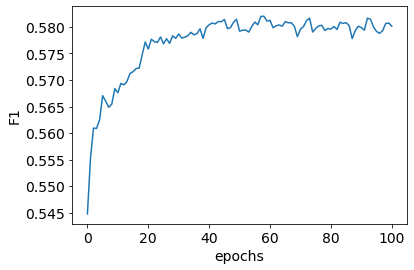

In [12]:
fontsize=14
plt.plot(metric_asfo_epoch)
plt.xlabel("epochs", fontsize=fontsize)
plt.ylabel("F1", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.savefig("datasets/emotions/emotions_F1_asof_epochs_myNetwork.png")

In [13]:
# print_thresholds(learned_AT_thresholds, nb_classes)

val_bin_pred = binarize_probs(val_pred_np, auto_thresholds)
test_bin_pred = binarize_probs(desed_pred_np, auto_thresholds)

print('val')
print_scores(val_gt_np, val_bin_pred)
print('desed')
print_scores(desed_gt_np, test_bin_pred)


val
              precision    recall  f1-score   support

           0      1.000     0.467     0.636        30
           1      0.909     0.333     0.488        30
           2      0.929     0.433     0.591        30
           3      0.857     0.400     0.545        30
           4      0.577     0.500     0.536        30
           5      0.852     0.767     0.807        30
           6      0.643     0.281     0.391        32
           7      0.439     0.714     0.543        35
           8      0.784     0.935     0.853        31
           9      0.612     0.857     0.714        35
          10      0.944     0.567     0.708        30
          11      0.429     0.750     0.545        60
          12      0.429     0.094     0.154        32
          13      0.514     0.613     0.559        31
          14      0.471     0.550     0.508        60
          15      0.621     0.600     0.610        30
          16      0.848     0.560     0.675        50

   micro avg      0.61

/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
save_thresholds(thresh, fpath)

# SGLthresh

In [7]:
from sgl_utils.sglThresh import ThresholdModel, SurrogateHeaviside, F1_loss_objective, macro_F1_loss_objective

Device in sglThresh.py cpu


In [12]:
# criterion = F1_loss_objective
criterion = macro_F1_loss_objective

THRESHmodel = ThresholdModel(threshold_fn=SurrogateHeaviside.apply, t=0.3, sigma=50., nb_classes=nb_classes)
THRESHmodel = THRESHmodel.to(device, dtype=torch.float)

# for el in THRESHmodel.parameters():
#     params = el.clone().detach().cpu()
#     print(params)

thresh = THRESHmodel.thresh
sigma = THRESHmodel.sigma
print(thresh)
print(sigma)

learning_rate = 1e-2

THRESHoptimizer = torch.optim.Adam(THRESHmodel.parameters(), lr=learning_rate)

# # # learn only the thresholds:
# THRESHoptimizer = torch.optim.Adam([
#                 {'params': THRESHmodel.thresh}
#             ], lr=learning_rate)

# # learn the thresholds and sigma:
# THRESHoptimizer = torch.optim.Adam([
#                 {'params': THRESHmodel.thresh},
#                 {'params': THRESHmodel.sigma, 'lr': 1e-2}
#             ], lr=learning_rate)


Parameter containing:
tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50.], device='cuda:0', requires_grad=True)


tensor([0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000])
Epoch [1/100], Loss: -0.5448, Duration: 0.0 s
threshs: tensor([0.2900, 0.3100, 0.2900, 0.2900, 0.3100, 0.3100, 0.2900, 0.2900, 0.2900,
        0.2900, 0.2900, 0.3100, 0.2900, 0.2900, 0.3100, 0.2900, 0.2900])
sigma: tensor([49.9900, 50.0100, 49.9900, 49.9900, 49.9900, 50.0099, 50.0100, 50.0100,
        50.0100, 50.0100, 49.9900, 50.0100, 50.0100, 49.9900, 49.9901, 50.0100,
        50.0099])
Epoch [2/100], Loss: -0.5565, Duration: 0.0 s
Epoch [3/100], Loss: -0.5651, Duration: 0.0 s
Epoch [4/100], Loss: -0.5666, Duration: 0.0 s
Epoch [5/100], Loss: -0.5699, Duration: 0.0 s
Epoch [6/100], Loss: -0.5769, Duration: 0.0 s
Epoch [7/100], Loss: -0.5793, Duration: 0.0 s
Epoch [8/100], Loss: -0.5811, Duration: 0.0 s
Epoch [9/100], Loss: -0.5860, Duration: 0.0 s
Epoch [10/100], Loss: -0.5898, Duration: 0.0 s
Epoch [11/100], Loss: -0.5928, Duration

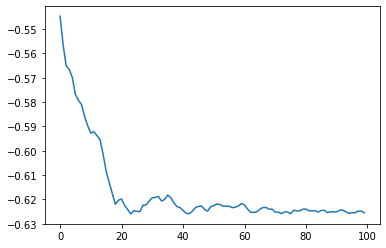

In [13]:
# Train the model, in batch mode
# num_epochs = 150
num_epochs = 100
# num_epochs = 300

# sigma = torch.nn.Parameter(torch.tensor(40.0), requires_grad=True)

cumul_delta_thresh = torch.zeros(nb_classes,)
delta_thresh = torch.zeros(nb_classes,)

el = next(THRESHmodel.parameters())
PREC_learned_AT_thresholds = el.clone().detach().cpu()
print(PREC_learned_AT_thresholds)
    
losses = []
for epoch in range(num_epochs):
    
    debut = time.time()
    
    THRESHmodel.train()
    
    # Forward pass
    outputs = THRESHmodel(val_pred_tensor).to(device)
    
    loss = criterion(outputs, val_gt_tensor)

    # Backward and optimize
    THRESHoptimizer.zero_grad()

    loss.backward()
#     loss.mean().backward()
#         loss.backward(at_batch_y)
    # loss.backward(torch.ones_like(loss))
    
    THRESHoptimizer.step()
    # THRESHmodel.clamp()
    losses.append(loss)
    
    duree_epoch = time.time() - debut

    print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
           .format(epoch+1, num_epochs, loss, duree_epoch))

    learned_AT_thresholds = THRESHmodel.thresh.clone().detach().cpu()

    delta_thresh = learned_AT_thresholds - PREC_learned_AT_thresholds
    cumul_delta_thresh += delta_thresh
    PREC_learned_AT_thresholds = learned_AT_thresholds
    if epoch % 10 == 0: 
        print('threshs:', learned_AT_thresholds)
        print('sigma:', THRESHmodel.sigma.clone().detach().cpu())
    # if torch.sum(delta_thresh) < 0.01: break
    
print('delta:', cumul_delta_thresh)
plt.figure()
# plt.figure(figsize=(8,6))
plt.plot(losses)

In [14]:
learned_AT_thresholds=THRESHmodel.thresh.clone().detach().cpu().numpy()
sigma = THRESHmodel.sigma.clone().detach().cpu().numpy()
learned_AT_thresholds, sigma

print_thresholds(learned_AT_thresholds, nb_classes)

0.158 0.323 0.208 0.163 0.424 0.399 0.122 0.217 0.272 0.265 0.152 0.646 0.113 0.157 0.337 0.238 0.125 


In [15]:
# print_thresholds(learned_AT_thresholds, nb_classes)
# val_bin_pred = val_pred_np>learned_AT_thresholds
# test_bin_pred = desed_pred_np>learned_AT_thresholds

val_bin_pred = binarize_probs(val_pred_np, learned_AT_thresholds)
test_bin_pred = binarize_probs(desed_pred_np, learned_AT_thresholds)

# print(val_bin_pred)

print('val')
print_scores(val_gt_np, val_bin_pred)
print('desed')
print_scores(desed_gt_np, test_bin_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)
# 0.3366 0.2834 0.2761 0.3185 0.2849 0.2611

val
              precision    recall  f1-score   support

           0      0.947     0.600     0.735        30
           1      0.909     0.333     0.488        30
           2      0.929     0.433     0.591        30
           3      0.889     0.533     0.667        30
           4      0.667     0.467     0.549        30
           5      0.852     0.767     0.807        30
           6      0.571     0.500     0.533        32
           7      0.450     0.771     0.568        35
           8      0.784     0.935     0.853        31
           9      0.625     0.857     0.723        35
          10      0.778     0.700     0.737        30
          11      0.487     0.650     0.557        60
          12      0.311     0.438     0.364        32
          13      0.543     0.613     0.576        31
          14      0.493     0.550     0.520        60
          15      0.633     0.633     0.633        30
          16      0.825     0.660     0.733        50

   micro avg      0.61

/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# myf1 = calculate_f1(desed_gt_np, desed_pred_np, thresholds=learned_AT_thresholds, average='micro')
# print("%.3f"%myf1)


0.719


# heuThresh

In [5]:
from heu_utils.heuThresh import heu_threshold_opti, heu_threshold_opti_meanF1

In [13]:
t=0.3
thresh = [t]*nb_classes

# class per class optim:
# sk_f1, best_f1, best_AT_thresholds, history = heu_threshold_opti(val_gt_np, val_pred_np, thresh)

# average F1 optim:
sk_f1, best_f1, best_AT_thresholds, history = heu_threshold_opti_meanF1(val_gt_np, val_pred_np, thresh, average='micro')

In [14]:
val_bin_pred = binarize_probs(val_pred_np, best_AT_thresholds)
test_bin_pred = binarize_probs(desed_pred_np, best_AT_thresholds)

# print(val_bin_pred)

print('val')
print_scores(val_gt_np, val_bin_pred)
print('desed')
print_scores(desed_gt_np, test_bin_pred)


val
              precision    recall  f1-score   support

           0      0.909     0.667     0.769        30
           1      0.833     0.333     0.476        30
           2      0.812     0.433     0.565        30
           3      0.889     0.533     0.667        30
           4      0.529     0.600     0.562        30
           5      0.821     0.767     0.793        30
           6      0.588     0.312     0.408        32
           7      0.447     0.600     0.512        35
           8      0.784     0.935     0.853        31
           9      0.508     0.886     0.646        35
          10      0.688     0.733     0.710        30
          11      0.387     0.800     0.522        60
          12      0.267     0.250     0.258        32
          13      0.500     0.645     0.563        31
          14      0.425     0.617     0.503        60
          15      0.633     0.633     0.633        30
          16      0.857     0.600     0.706        50

   micro avg      0.56

/home/thomas/tools/miniconda2/envs/envPytorch1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
toto = np.array([0.534, 0.539, 0.534])
print(np.std(toto))

0.0023570226039551605


In [15]:
print_thresholds(best_AT_thresholds, nb_classes)

0.076 0.270 0.172 0.196 0.209 0.300 0.202 0.345 0.267 0.178 0.082 0.470 0.150 0.145 0.235 0.256 0.214 


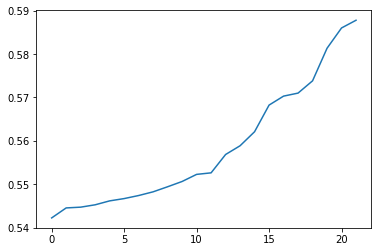

In [16]:
plt.plot(history['best_f1'])